In [1]:
import os, os.path
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.special import sph_harm
import weave
from weave import converters
from numba import jit, vectorize
import numexpr
%load_ext Cython

In [2]:
from colloids import boo, particles, periodic

In [3]:
path = '/data/mleocmach/Documents/Tsurusawa/0_Data_retracked/3_DenseGel/163A/2_ageing/'
pos = np.loadtxt(os.path.join(path, '163A_1415_ageing_t000.dat'), skiprows=2)
bonds = np.loadtxt(os.path.join(path, '163A_1415_ageing_t000.bonds'), dtype=int)
inside = np.min((pos-pos.min(0)>14) & (pos.max()-pos>14), -1)
ngbs = particles.bonds2ngbs(bonds, len(pos))

In [13]:
%timeit boo.weave_qlm(pos, ngbs, inside)

1 loop, best of 3: 305 ms per loop


In [4]:
%timeit boo.bonds2qlm(pos, bonds)

1 loops, best of 3: 517 ms per loop


In [22]:
import math
def python_qlm(pos, ngbs, inside, l=6):
    qlm = np.zeros([len(pos), l+1], np.complex128)
    cart = np.zeros(3)
    sph = np.zeros(3)
    for i in range(ngbs.shape[0]):
        if not inside[i]:
            continue
        nb = 0
        for j in range(ngbs.shape[1]):
            q = ngbs[i,j]
            if q < 0 or q >= len(pos):
                continue
            nb += 1
            cart[:] = pos[i] - pos[q]
            sph[0] = cart[0]*cart[0] + cart[1]*cart[1] + cart[2]*cart[2]
            if cart[2]**2 == sph[0] or sph[0]+1.0 == 1.0:
                sph[1:] = 0
            else:
                sph[0] = math.sqrt(sph[0])
                sph[1] = math.acos(cart[2]/sph[0])
                sph[2] = math.atan2(cart[1], cart[0])
                if sph[2] < 0:
                    sph[2] += 2.0*math.pi
            qlm[i] += sph_harm(
                np.arange(l+1), l, 
                sph[2], 
                sph[1]
                )
        if nb>0:
            qlm[i] /= nb
    return qlm

In [23]:
%timeit python_qlm(pos, ngbs, inside)

1 loop, best of 3: 4.28 s per loop


In [5]:
%%cython --annotate
import numpy as np
from scipy.special.cython_special cimport sph_harm
cimport numpy as np
from libc.math cimport sqrt, acos, atan2, M_PI
cimport cython

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True) # turn off division by zero checking for entire function
def cython_qlm(
    np.ndarray[np.float64_t, ndim=2] pos, 
    np.ndarray[np.int64_t, ndim=2] ngbs, 
    np.ndarray[np.uint8_t, ndim=1, cast=True] inside, 
    int l=6
):
    cdef int i,j, q, nb, m, d
    cdef double r, r2, theta, phi, z
    cdef long Npos = pos.shape[0]
    cdef long Nngb = ngbs.shape[1]
    cdef np.ndarray[dtype=np.complex128_t, ndim=2] qlm = np.zeros([len(pos), l+1], np.complex128)
    #cdef np.ndarray[dtype=double, ndim=1] cart = np.zeros(3, float)
    cdef double[3] cart
    for i in range(Npos):
        if not inside[i]:
            continue
        nb = 0
        for j in range(Nngb):
            q = ngbs[i,j]
            if q < 0 or q >= Npos:
                continue
            nb += 1
            for d in range(3):
                cart[d] = pos[i,d] - pos[q,d]
            r2 = cart[0]**2 + cart[1]**2 + cart[2]**2
            if cart[2]**2 == r2 or r2+1.0 == 1.0:
                theta = 0
                phi = 0
            else:
                r = sqrt(r2)
                z = cart[2]
                phi = acos(z/r)
                theta = atan2(cart[1], cart[0])
                if theta < 0:
                    theta += 2.0*M_PI
            for m in range(l+1):
                qlm[i,m] = qlm[i,m] + sph_harm(m, l, theta, phi)
        if nb>0:
            for m in range(l+1):
                qlm[i,m] = qlm[i,m] / nb
    return qlm

In file included from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1809:0,
                 from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /data/mleocmach/.cache/ipython/cython/_cython_magic_dff929309038b07cc4cb4b3c6acc7e68.c:257:
/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
In file included from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:27:0,
                 from /home/mathieu/anaconda3/env

In [6]:
%timeit cython_qlm(pos, ngbs, inside)

1 loops, best of 3: 540 ms per loop


In [94]:
sph_harm?

In [134]:
qlm_w = boo.weave_qlm(pos, ngbs, inside)

In [201]:
qlm_c = cython_qlm(pos, ngbs, inside)

In [202]:
np.mean(np.abs(qlm_w - qlm_c)<1e-16)

0.81391235399957307

In [187]:
qlm_w[0]

array([ 0.04028486+0.j        ,  0.05799787+0.06639547j,
        0.04605032-0.09580622j, -0.05903408-0.0054351j ,
        0.13045725-0.20548051j, -0.18253487-0.07674777j,
        0.09087308+0.00445716j])

In [188]:
qlm_c[0]

array([ 0.04028486+0.j        ,  0.05799787+0.06639547j,
        0.04605032-0.09580622j, -0.05903408-0.0054351j ,
        0.13045725-0.20548051j, -0.18253487-0.07674777j,
        0.09087308+0.00445716j])

In [183]:
sph_harm(0, 6, 3.685749891321086, 1.4481876153314692)

(-0.22243770324198525+0j)

In [182]:
sph_harm?

# Periodicity

In [3]:
periodic.periodify(np.array([[0,0,0]]), np.array([[1,1,1]]))

array([[ 1.,  1.,  1.]])

In [4]:
periodic.periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,3,3])

array([[ 1.,  1.,  1.]])

In [5]:
periodic.periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,1,2])

array([[ 1.,  0.,  1.]])

In [6]:
periodic.periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [0.9,0.5,0.5])

array([[ 0.1,  0. ,  0. ]])

In [10]:
reload(periodic)

<module 'colloids.periodic' from '/home/mathieu/src/colloids/python/colloids/periodic.py'>

In [3]:
u = np.zeros([1000000, 3])
v = 3*np.random.rand(1000000, 3)
u.shape, v.shape

((1000000, 3), (1000000, 3))

In [8]:
%timeit periodic.periodify(u, v, [0.9,0.5,0.5])

1 loop, best of 3: 388 ms per loop


In [9]:
def python_periodify(u, v, periods=None):
    assert u.shape == v.shape
    diff = np.array(v, float) - u
    if periods is None:
        return diff
    assert len(periods) == u.shape[-1]
    #ensures the largest coordinate is smaller than half a period
    half = 0.5*np.array(periods)
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            while diff[i,j] > half[j]:
                diff[i,j] -= periods[j]
            while diff[i,j] < -half[j]:
                diff[i,j] += periods[j]
    return diff

In [10]:
python_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]))

array([[ 1.,  1.,  1.]])

In [11]:
python_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,3,3])

array([[ 1.,  1.,  1.]])

In [12]:
python_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,1,2])

array([[ 1.,  0.,  1.]])

In [13]:
python_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [0.9,0.5,0.5])

array([[ 0.1,  0. ,  0. ]])

In [14]:
%timeit python_periodify(u, v, [0.9,0.5,0.5])

1 loop, best of 3: 8.17 s per loop


In [26]:
def numpy_periodify(u, v, periods=None):
    """Given two arrays of points in a d-dimentional space with periodic boundary conditions, find the shortest vector between each pair"""
    assert u.shape == v.shape
    diff = np.array(v, float) - u
    if periods is None:
        return diff
    assert len(periods) == u.shape[-1]
    box_r = 1/np.array(periods)
    return diff - periods * np.floor(diff * box_r + 0.5)
    k = diff * box_r  + np.where(diff >= 0.5, 0.5, -0.5)
    diff -= k.astype(int) * periods
    return diff

In [27]:
%timeit numpy_periodify(u, v, [0.9,0.5,0.5])

10 loops, best of 3: 90.3 ms per loop


In [26]:
from numba import guvectorize
from math import floor
#@jit(["float64[:](float64[:], float64[:], float64)"], nopython=True)
#@guvectorize(["(float64[:], float64[:], float64[:], float64[:])"], '(n),(n),()->(n)')
def numba_periodify(u, v, period, diff):
    """Given two arrays of points in a d-dimentional space with periodic boundary conditions, find the shortest vector between each pair"""
    #assert u.shape == v.shape
    for i in range(u.shape[0]):
        diff[i] = v[i] - u[i]
    if period[0] > 0:
        for i in range(u.shape[0]):
            diff[i] -= period[0] * floor(diff[i] /period[0] + 0.5)
     #   diff -= period[0] * np.floor(diff /period[0] + 0.5)
      #  print('a')
    #k = diff * box_r  + np.where(diff >= 0.5, 0.5, -0.5)
    #diff -= k.astype(int) * periods
    #return diff

In [27]:
numba_periodify(np.array([0,0,0],float), np.array([1,1,1], float), 0.)

array([ 1.,  1.,  1.])

In [28]:
numba_periodify(np.array([0,0,0], float), np.array([1,1,1], float), 3)

array([ 1.,  1.,  1.])

In [29]:
numba_periodify(np.array([0,0,0], float), np.array([1,1,1], float), 1)

array([ 0.,  0.,  0.])

In [30]:
numba_periodify(np.array([0,0,0], float), np.array([1,1,1], float), 0.9)

array([ 0.1,  0.1,  0.1])

In [35]:
numba_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), np.transpose([[0.9,0.5,0.5]]))

array([[[ 0.1,  0.1,  0.1]],

       [[ 0. ,  0. ,  0. ]],

       [[ 0. ,  0. ,  0. ]]])

In [31]:
%timeit numba_periodify(u.ravel(), v.ravel(), 0.9)

10 loops, best of 3: 24.6 ms per loop


In [53]:
%%cython --annotate
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True) # turn off division by zero checking for entire function
def cython_periodify(
    np.ndarray[np.float64_t, ndim=2] u, 
    np.ndarray[np.float64_t, ndim=2] v, 
    periods=None
):
    assert u.shape[0] == v.shape[0]
    assert u.shape[1] == v.shape[1]
    #cdef np.ndarray[np.float64_t, ndim=2] diff = v - u
    if periods is None:
        return v - u
    assert len(periods) == u.shape[1]
    cdef np.ndarray[np.float64_t, ndim=2] diff = np.zeros_like(u)
    #ensures the largest coordinate is smaller than half a period
    cdef np.ndarray[np.float64_t, ndim=1] pers = np.array(periods)
    cdef np.ndarray[np.float64_t, ndim=1] half = 0.5*np.array(periods)
    cdef int i,j
    cdef float d,h,p
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            d = v[i,j] - u[i,j]
            h = half[j]
            p = pers[j]
            while d > h:
                d -= p
            while d < -h:
                d += p
            diff[i,j] = d
    return diff

In [54]:
%timeit cython_periodify(u, v, np.array([0.9,0.5,0.5]))

10 loops, best of 3: 55.4 ms per loop


In [47]:
from numba import vectorize, float64
from math import floor
@vectorize([float64(float64,float64,float64)], nopython=True)
def v_periodify(u,v,period=-1.0):
    diff = v - u
    if period <= 0:
        return diff
    return diff - period * floor(diff /period + 0.5)

In [48]:
v_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), -1)

array([[ 1.,  1.,  1.]])

In [49]:
v_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,3,3])

array([[ 1.,  1.,  1.]])

In [50]:
v_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,1,2])

array([[ 1.,  0., -1.]])

In [51]:
v_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [0.9,0.5,0.5])

array([[ 0.1,  0. ,  0. ]])

In [52]:
%timeit v_periodify(u, v, 0.9)

100 loops, best of 3: 15.8 ms per loop


In [55]:
v_periodify(u, v, 0.9).shape

(1000000, 3)

In [56]:
v_periodify(u, v, [0.9,0.5,0.5]).shape

(1000000, 3)

## $w_\ell$

$$ w_\ell = \sum_{m_1+m_2+m_3=0} 
			\left( \begin{array}{ccc}
				\ell & \ell & \ell \\
				m_1 & m_2 & m_3 
			\end{array} \right)
			q_{\ell m_1} q_{\ell m_2} q_{\ell m_3}
			$$

In [7]:
qlm = boo.bonds2qlm(pos, bonds)

In [9]:
%timeit boo.wl(qlm)

1 loops, best of 3: 482 ms per loop


In [21]:
from colloids.boo import get_qlm, get_w3j
def python_wl(qlm):
    l = qlm.shape[1]-1
    w = np.zeros(qlm.shape[0], qlm.dtype)
    for m1 in range(-l, l+1):
        for m2 in range(-l, l+1):
            m3 = -m1-m2
            if -l<=m3 and m3<=l:
                w+= get_w3j(l, [m1, m2, m3]) * get_qlm(qlm, m1) * get_qlm(qlm, m2) * get_qlm(qlm, m3)
    return w.real

In [31]:
%timeit python_wl(qlm)

10 loops, best of 3: 113 ms per loop


In [18]:
np.sum(boo.wl(qlm) - python_wl(qlm).real > 1e-12)

0

In [30]:
@jit
def numba_wl(qlm):
    l = qlm.shape[1]-1
    w = np.zeros(qlm.shape[0], qlm.dtype)
    for m1 in range(-l, l+1):
        for m2 in range(-l, l+1):
            m3 = -m1-m2
            if -l<=m3 and m3<=l:
                w+= get_w3j(l, [m1, m2, m3]) * get_qlm(qlm, m1) * get_qlm(qlm, m2) * get_qlm(qlm, m3)
    return w.real

In [33]:
%timeit numba_wl(qlm)

10 loops, best of 3: 111 ms per loop


## Spatial correlation

In [27]:
def coarsegrain_qlm(qlm, bonds, inside):
    """Coarse grain the bond orientational order on the neighbourhood of a particle
    $$Q_{\ell m}(i) = \frac{1}{N_i+1}\left( q_{\ell m}(i) +  \sum_{j=0}^{N_i} q_{\ell m}(j)\right)$$
    Returns Qlm and the mask of the valid particles
    """
    #Valid particles must be valid themselves have only valid neighbours
    inside2 = np.copy(inside)
    np.bitwise_and.at(inside2, bonds[:,0], inside[bonds[:,1]])
    np.bitwise_and.at(inside2, bonds[:,1], inside[bonds[:,0]])
    #number of neighbours
    Nngb = np.zeros(len(qlm), int)
    np.add.at(Nngb, bonds.ravel(), 1)
    #sum the boo coefficients of all the neighbours
    Qlm = np.zeros_like(qlm)
    np.add.at(Qlm, bonds[:,0], qlm[bonds[:,1]])
    np.add.at(Qlm, bonds[:,1], qlm[bonds[:,0]])
    Qlm[np.bitwise_not(inside2)] = 0
    return Qlm / np.maximum(1, Nngb)[:,None], inside2

In [37]:
Qlm, inside2 = coarsegrain_qlm(qlm, bonds, inside)

In [29]:
%timeit coarsegrain_qlm(qlm, bonds, inside)

1 loops, best of 3: 220 ms per loop


In [34]:
@jit
def numba_coarsegrain_qlm(qlm, bonds, inside):
    """Coarse grain the bond orientational order on the neighbourhood of a particle
    $$Q_{\ell m}(i) = \frac{1}{N_i+1}\left( q_{\ell m}(i) +  \sum_{j=0}^{N_i} q_{\ell m}(j)\right)$$
    Returns Qlm and the mask of the valid particles
    """
    #Valid particles must be valid themselves have only valid neighbours
    inside2 = np.copy(inside)
    np.bitwise_and.at(inside2, bonds[:,0], inside[bonds[:,1]])
    np.bitwise_and.at(inside2, bonds[:,1], inside[bonds[:,0]])
    #number of neighbours
    Nngb = np.zeros(len(qlm), int)
    np.add.at(Nngb, bonds.ravel(), 1)
    #sum the boo coefficients of all the neighbours
    Qlm = np.zeros_like(qlm)
    np.add.at(Qlm, bonds[:,0], qlm[bonds[:,1]])
    np.add.at(Qlm, bonds[:,1], qlm[bonds[:,0]])
    Qlm[np.bitwise_not(inside2)] = 0
    return Qlm / np.maximum(1, Nngb)[:,None], inside2

In [36]:
%timeit numba_coarsegrain_qlm(qlm, bonds, inside)

1 loops, best of 3: 227 ms per loop


In [58]:
maxdist = 30.0
bounds = np.vstack((pos[inside2].min(0)+maxdist, pos[inside2].max(0)-maxdist))
is_center = (pos>bounds[0]).min(1) & (pos<bounds[1]).min(1)

In [59]:
hq, hQ, g = boo.gG_l(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

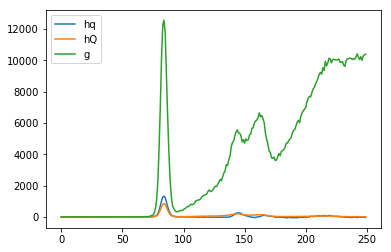

In [60]:
plt.plot(hq, label='hq')
plt.plot(hQ, label='hQ')
plt.plot(g, label='g')
plt.legend()

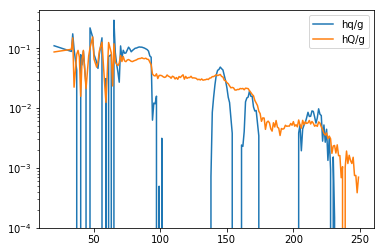

In [71]:
good = g>1
plt.plot(np.where(good)[0], hq[good]/g[good], label='hq/g')
plt.plot(np.where(good)[0], hQ[good]/g[good], label='hQ/g')
plt.yscale('log')
plt.legend()

In [255]:
%timeit boo.gG_l(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 854 ms per loop


In [66]:
maxdist = 60.0
bounds = np.vstack((pos[inside2].min(0)+maxdist, pos[inside2].max(0)-maxdist))
is_center2 = (pos>bounds[0]).min(1) & (pos<bounds[1]).min(1)

In [67]:
hq2, hQ2, g2 = boo.gG_l(pos, qlm, Qlm, is_center2, Nbins=250, maxdist=60.0)

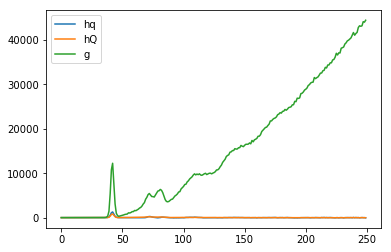

In [68]:
plt.plot(hq2, label='hq')
plt.plot(hQ2, label='hQ')
plt.plot(g2, label='g')
plt.legend()

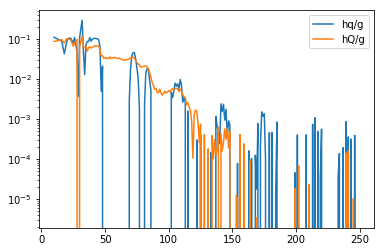

In [70]:
good = g2>1
plt.plot(np.where(good)[0], hq2[good]/g2[good], label='hq/g')
plt.plot(np.where(good)[0], hQ2[good]/g2[good], label='hQ/g')
plt.yscale('log')
plt.legend()

In [45]:
%timeit boo.gG_l(pos, qlm, Qlm, is_center2, Nbins=1000, maxdist=120.0)

1 loops, best of 3: 1.15 s per loop


In [106]:
from scipy.spatial import cKDTree as KDTree
from colloids.boo import boo_product

def gG_l(pos, qlms, Qlms, is_center, Nbins, maxdist):
    """Spatial correlation of the qlms and the Qlms (non normalized.
    For each particle tagged as is_center, do the cross product between their qlm, their Qlm and count, 
    then bin each quantity with respect to distance. 
    The two first sums need to be normalised by the last one.
    
     - pos is a Nxd array of coordinates, with d the dimension of space
     - qlm is a Nx(2l+1) array of boo coordinates for l-fold symmetry
     - Qlm is the coarse-grained version of qlm
     - is_center is a N array of booleans. For example all particles further away than maxdist from any edge of the box.
     - Nbins is the number of bins along r
     - maxdist is the maximum distance considered"""
    assert len(pos) == len(qlms)
    assert len(qlms) == len(Qlms)
    assert len(is_center) == len(pos)
    maxsq = float(maxdist**2)
    hQ = np.zeros(Nbins)
    hq = np.zeros(Nbins)
    g = np.zeros(Nbins, int)
    #spatial indexing
    tree = KDTree(pos, 12)
    for i in np.where(is_center)[0]:
        js = np.array(tree.query_ball_point(pos[i], maxdist))
        js = js[js!=i]
        rs = np.sqrt(np.sum((pos[js] - pos[i])**2, -1)) / maxdist * g.shape[0]
        pqs = boo_product(qlms[i][None,:], qlms[js])
        pQs = boo_product(Qlms[i][None,:], Qlms[js])
        np.add.at(g, rs.astype(int), 1)
        np.add.at(hq, rs.astype(int), pqs)
        np.add.at(hQ, rs.astype(int), pQs)
    return hq, hQ, g

In [102]:
hq1, hQ1, g1 = gG_l(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

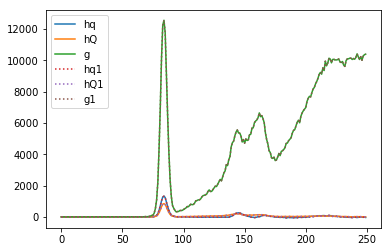

In [84]:
plt.plot(hq, label='hq')
plt.plot(hQ, label='hQ')
plt.plot(g, label='g')
plt.plot(hq1, ls=':', label='hq1')
plt.plot(hQ1, ls=':', label='hQ1')
plt.plot(g1, ls=':', label='g1')
plt.legend()

In [86]:
np.abs(g - g1).max(), np.abs(hq - hq1).max(), np.abs(hQ - hQ1).max()

(0, 1.2505552149377763e-11, 7.0485839387401938e-12)

In [96]:
%timeit gG_l(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 5.98 s per loop


In [92]:
%timeit boo.gG_l(pos, qlm, Qlm, is_center2, Nbins=1000, maxdist=120.0)

1 loops, best of 3: 19.3 s per loop


In [235]:
def gG_l_tree(pos, qlms, Qlms, is_center, Nbins, maxdist):
    """Spatial correlation of the qlms and the Qlms (non normalized.
    For each particle tagged as is_center, do the cross product between their qlm, their Qlm and count, 
    then bin each quantity with respect to distance. 
    The two first sums need to be normalised by the last one.
    
     - pos is a Nxd array of coordinates, with d the dimension of space
     - qlm is a Nx(2l+1) array of boo coordinates for l-fold symmetry
     - Qlm is the coarse-grained version of qlm
     - is_center is a N array of booleans. For example all particles further away than maxdist from any edge of the box.
     - Nbins is the number of bins along r
     - maxdist is the maximum distance considered"""
    assert len(pos) == len(qlms)
    assert len(qlms) == len(Qlms)
    assert len(is_center) == len(pos)
    rsq2r = np.sqrt(np.arange(Nbins**2)).astype(int)
    l2r = float((Nbins/maxdist)**2)
    #maxsq = float(maxdist**2)
    hQ = np.zeros(Nbins)
    hq = np.zeros(Nbins)
    g = np.zeros(Nbins, int)
    #spatial indexing
    tree = KDTree(pos, 12)
    centertree = KDTree(pos[is_center], 12)
    for i, js in zip(np.where(is_center)[0], centertree.query_ball_tree(tree, maxdist)):
    #for i in np.where(is_center)[0]:
        #js = np.array(tree.query_ball_point(pos[i], maxdist))
        js = np.array(js)
        js = js[js!=i]
        #rs = np.sqrt(np.sum((pos[js] - pos[i])**2, -1)) / maxdist * g.shape[0]
        #rsqs = numexpr.evaluate('sum((a-b)**2, axis=1)', {'a':pos[js], 'b':pos[i]}) * l2r
        rsqs = np.sum((pos[js] - pos[i])**2, -1) * l2r
        rs = rsq2r[rsqs.astype(int)]
        pqs = boo_product(qlms[i][None,:], qlms[js])
        #pQs = boo_product(Qlms[i][None,:], Qlms[js])
        np.add.at(g, rs, 1)
        np.add.at(hq, rs.astype(int), pqs)
        #np.add.at(hQ, rs.astype(int), pQs)
    return hq, hQ, g

In [236]:
%timeit gG_l_tree(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 4.16 s per loop


In [260]:
def gG_l_record(pos, qlms, Qlms, is_center, Nbins, maxdist):
    """Spatial correlation of the qlms and the Qlms (non normalized.
    For each particle tagged as is_center, do the cross product between their qlm, their Qlm and count, 
    then bin each quantity with respect to distance. 
    The two first sums need to be normalised by the last one.
    
     - pos is a Nxd array of coordinates, with d the dimension of space
     - qlm is a Nx(2l+1) array of boo coordinates for l-fold symmetry
     - Qlm is the coarse-grained version of qlm
     - is_center is a N array of booleans. For example all particles further away than maxdist from any edge of the box.
     - Nbins is the number of bins along r
     - maxdist is the maximum distance considered"""
    assert len(pos) == len(qlms)
    assert len(qlms) == len(Qlms)
    assert len(is_center) == len(pos)
    #conversion factor between indices and bins
    l2r = Nbins/maxdist
    #result containers
    hQ = np.zeros(Nbins)
    hq = np.zeros(Nbins)
    g = np.zeros(Nbins, int)
    #spatial indexing
    tree = KDTree(pos, 12)
    centertree = KDTree(pos[is_center], 12)
    #all pairs of points closer than maxdist with their distances, in a record array
    query = centertree.sparse_distance_matrix(tree, maxdist, output_type='ndarray')
    #keep only pairs where the points are distinct
    centerindex = np.where(is_center)[0]
    query['i'] = centerindex[query['i']]
    good = query['i'] != query['j']
    query = query[good]
    #binning of distances
    rs = (query['v'] * l2r).astype(int)
    np.add.at(g, rs, 1)
    #binning of boo cross products
    pqQs = np.empty((len(rs),2))
    pqQs[:,0] = boo_product(qlms[query['i']], qlms[query['j']])
    pqQs[:,1] = boo_product(Qlms[query['i']], Qlms[query['j']])
    np.add.at(hqQ, rs, pqQs)
    return hqQ[:,0], hqQ[:,1], g

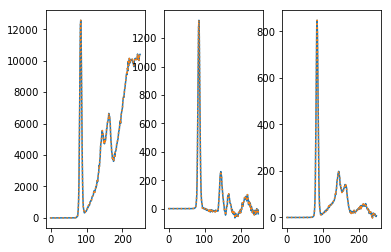

In [261]:
hq3, hQ3, g3 = gG_l_record(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)
plt.subplot(1,3,1)
plt.plot(g)
plt.plot(g3, ls=':')
plt.subplot(1,3,2)
plt.plot(hq, label='hq')
plt.plot(hq3, ls=':', label='hq3')
plt.subplot(1,3,3)
plt.plot(hQ, label='hQ')
plt.plot(hQ3, ls=':', label='hQ3')

In [265]:
%timeit gG_l_record(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 1.15 s per loop


In [212]:
%debug

> <ipython-input-210-923716ae9c93>(27)gG_l_record()
     26     query = centertree.sparse_distance_matrix(tree, maxdist, output_type='ndarray')
---> 27     query.i = centerindex[query.i]
     28     good = query.j != query.i

ipdb> query.dtype
dtype([('i', '<i8'), ('j', '<i8'), ('v', '<f8')], align=True)
ipdb> query['i'].shape
(962782,)
ipdb> q


In [206]:
%%cython --annotate
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

from scipy.spatial import cKDTree as KDTree
#from scipy.spatial cimport cKDTree as KDTree
from colloids import particles, boo
from colloids.boo import boo_product

#_dtype = [('i',np.intp),('j',np.intp),('v',np.float64)]
#res_dtype = np.dtype(_dtype, align = True)
cdef packed struct ijdist:
    np.intp_t i,j
    np.float64_t v

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True) # turn off division by zero checking for entire function
def cython_gG_l(
    np.ndarray[np.float64_t, ndim=2] pos, 
    qlms, Qlms, 
    is_center, 
    int Nbins, float maxdist):
    """Spatial correlation of the qlms and the Qlms (non normalized.
    For each particle tagged as is_center, do the cross product between their qlm, their Qlm and count, 
    then bin each quantity with respect to distance. 
    The two first sums need to be normalised by the last one.
    
     - pos is a Nxd array of coordinates, with d the dimension of space
     - qlm is a Nx(2l+1) array of boo coordinates for l-fold symmetry
     - Qlm is the coarse-grained version of qlm
     - is_center is a N array of booleans. For example all particles further away than maxdist from any edge of the box.
     - Nbins is the number of bins along r
     - maxdist is the maximum distance considered"""
    cdef int i,it,j,r
    cdef float rsq
    assert len(pos) == len(qlms)
    assert len(qlms) == len(Qlms)
    assert len(is_center) == len(pos)
    #cdef np.ndarray[np.int64_t, ndim=1]  rsq2r = np.sqrt(np.arange(Nbins**2)).astype(int)
    cdef float l2r = (Nbins/maxdist)#**2
    #maxsq = float(maxdist**2)
    hQ = np.zeros(Nbins)
    hq = np.zeros(Nbins)
    g = np.zeros(Nbins, int)
    #spatial indexing
    tree = KDTree(pos, 12)
    centertree = KDTree(pos[is_center], 12)
    centerindex = np.where(is_center)[0]
    cdef np.ndarray[ijdist, ndim=1] query = centertree.sparse_distance_matrix(tree, maxdist, output_type='ndarray')
    for it in range(query.shape[0]):
        i = centerindex[query[it].i]
        if i==query[it].j:
            continue
        r = int(l2r * query[it].v)
        g[r] += 1
    return hq, hQ, g

building '_cython_magic_8e21d051df37107da4dfc0d81ba886b3' extension
C compiler: gcc -pthread -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC

compile options: '-I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs

In [208]:
%timeit cython_gG_l(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 583 ms per loop


## periodic correlation

In [3]:
pos = np.loadtxt('../../../multiscale/test_input/3d_6_0.54_0.dat')

In [22]:
pos.min(0), pos.max(0)

(array([ 0.0167643 ,  0.017033  ,  0.00916006,  3.22366   ]),
 array([ 202.999  ,  202.999  ,  202.985  ,    4.85154]))

In [8]:
g = periodic.get_rdf(0, pos[:,:-1], 100, 203.0)

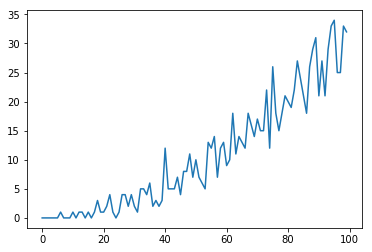

In [9]:
plt.plot(g)

In [13]:
g = periodic.get_mono_rdf(pos[:,:-1], 1000, 203.0)

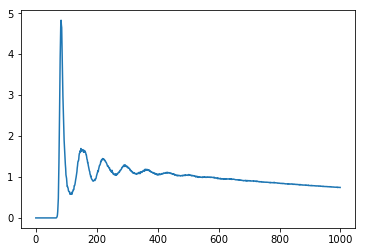

In [20]:
plt.plot(g.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)))

In [70]:
%timeit periodic.get_mono_rdf(pos[:,:-1], 1000, 203.0)

1 loop, best of 3: 2.87 s per loop


In [34]:
def get_mono_rdf(pos, Nbins, L):
    maxdist = L/2.0
    g = np.zeros([len(pos), Nbins], int)
    #conversion factor between indices and bins
    l2r = Nbins/maxdist
    for i in range(len(pos)):
        good = np.ones(len(pos), bool)
        good[i] = False
        dists = np.sqrt((periodic.periodify(pos[i], pos[good], L)**2).sum(-1))
        rs = (dists * l2r).astype(int)
        np.add.at(g[i], rs[rs<Nbins], 1)
    return g

In [56]:
g2 = get_mono_rdf(pos[:,:-1], 1000, 203.0)

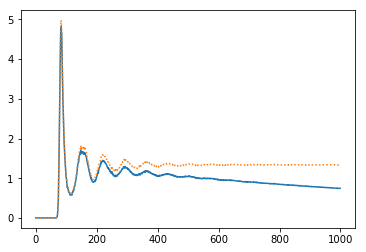

In [32]:
plt.plot(g.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)))
plt.plot(g2.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)), ls=':')

In [78]:
from numba import float64, int64
from math import sqrt, floor
@jit(int64[:,:](float64[:,:], int64, float64), nopython=True)
def numba_get_mono_rdf(pos, Nbins, L):
    maxdist = L/2.0
    g = np.zeros((pos.shape[0], Nbins), np.int64)
    #conversion factor between indices and bins
    l2r = Nbins/maxdist
    for i in range(pos.shape[0]):
        for j in range(pos.shape[0]):
            if j==i:
                continue
            dist = 0
            for d in range(pos.shape[1]):
                diff = pos[i,d] - pos[j,d]
                diff -= L * floor(diff /L + 0.5)
                dist += diff*diff
            dist = sqrt(dist)
            r = int(dist * l2r)
            if r<Nbins:
                g[i,r] += 1
    return g

In [79]:
g3 = numba_get_mono_rdf(pos[:,:-1], 1000, 203.0)

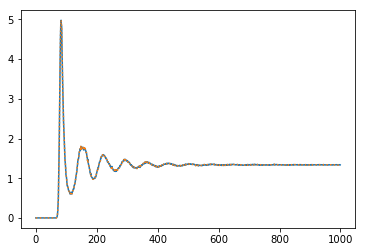

In [80]:
plt.plot(g2.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)))
plt.plot(g3.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)), ls=':')

In [74]:
%timeit numba_get_mono_rdf(pos[:,:-1], 1000, 203.0)

1 loop, best of 3: 7.6 s per loop


In [68]:
%%cython --annotate
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt, floor

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True) # turn off division by zero checking for entire function
def cython_get_mono_rdf(
    np.ndarray[np.float64_t, ndim=2] pos, 
    int Nbins, 
    float L
):
    cdef float maxdist = L/2.0
    cdef np.ndarray[np.int64_t, ndim=2] g = np.zeros((pos.shape[0], Nbins), np.int64)
    #conversion factor between indices and bins
    cdef float l2r = Nbins/maxdist
    cdef int i,j, r, d
    cdef float dist, diff
    for i in range(pos.shape[0]):
        for j in range(pos.shape[0]):
            if j==i:
                continue
            dist = 0
            for d in range(pos.shape[1]):
                diff = pos[i,d] - pos[j,d]
                diff -= L * floor(diff /L + 0.5)
                dist += diff*diff
            dist = sqrt(dist)
            r = int(dist * l2r)
            if r<Nbins:
                g[i,r] += 1
    return g

building '_cython_magic_c87991076bc3cdeee25a1abb9dec57dc' extension
C compiler: gcc -pthread -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC

compile options: '-I/home/mathieu/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/py27/include/python2.7 -c'
gcc: /home/mathieu/.cache/ipython/cython/_cython_magic_c87991076bc3cdeee25a1abb9dec57dc.c
In file included from /home/mathieu/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1809:0,
                 from /home/mathieu/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /home/mathieu/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 fro

In [65]:
g4 = cython_get_mono_rdf(pos[:,:-1], 1000, 203.0)

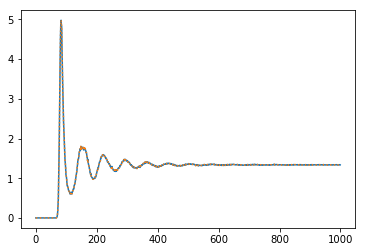

In [66]:
plt.plot(g2.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)))
plt.plot(g4.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)), ls=':')

In [69]:
%timeit cython_get_mono_rdf(pos[:,:-1], 1000, 203.0)

1 loop, best of 3: 7.99 s per loop
